In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import pickle
from glob import glob
from regularizepsf.fitter import CoordinateIdentifier, CoordinatePatchCollection
from regularizepsf.corrector import calculate_covering, ArrayCorrector

In [2]:
img_count = 540
patch_size = 450
psf_size = 32
img_size = 2048

In [3]:
corners = calculate_covering((img_size, img_size), patch_size)
x = corners[:, 0][:25]
y = corners[:, 0][:25]

In [4]:
corners.shape

(121, 2)

In [5]:
for i in range(img_count):
    cor_fn = f"/Users/jhughes/Desktop/projects/PUNCH/psf_paper/punch_corrections/campaign2_night2_phase3_calibrated_{i:03d}.npy"
    raw_fn = f"/Users/jhughes/Nextcloud/23103_PUNCH_Data/SOC_Data/PUNCH_WFI_EM_Starfield_campaign2_night2_phase3/calibrated/campaign2_night2_phase3_calibrated_{i:03d}.fits.gz"
    with fits.open(raw_fn) as hdul:
        header = hdul[0].header
        raw = hdul[0].data
    cor = np.load(cor_fn)

    fits.writeto(f"/Users/jhughes/Desktop/projects/PUNCH/psf_paper/punch_corrections/fits/campaign2_night2_phase3_calibrated_corrected_{i:03d}.fits",
                 cor, header, overwrite=True)

In [6]:
# read in the star list and create a set of coordinates to use
star_list = pd.read_csv("/Users/jhughes/Desktop/projects/PUNCH/wfi_analysis/wfi/star_list_full_correctangles.csv")
with open("/Users/jhughes/Desktop/projects/PUNCH/wfi_analysis/wfi/test_results_full_correctangles.pkl", 'rb') as f:
    results = pickle.load(f)
coordinates = []
for row in star_list.iterrows():
    row = row[1]
    for t in range(540):
        hip = int(row['HIP'])
        x, y = row[f'expected_pix_x_{t:03d}'], row[f'expected_pix_y_{t:03d}']
        if not (np.isnan(x) and np.isnan(y)):
            x, y = int(x), int(y)
            if 0 < x < 2048 and 0 < y < 2048:
                this_result = results[hip][t]
                if this_result:
                    offset_x = this_result.params['centroid_x'].value - 16
                    offset_y = this_result.params['centroid_y'].value - 16
                    coordinates.append((t, x + offset_x, y + offset_y))
coordinates = np.array(coordinates).astype(int)

In [7]:
# # Create the CoordinatePatchCollection
half_size = psf_size // 2
image_directory = ("/Users/jhughes/Desktop/projects/PUNCH/psf_paper/punch_corrections/fits/")
image_filenames = sorted(glob(image_directory + "*corrected*.fits"))

out = CoordinatePatchCollection(dict())

for t in range(img_count):
    locs = np.where(coordinates[:, 0] == t)[0]
    with fits.open(image_filenames[t]) as hdul:
        this_image = hdul[0].data
    for _, x, y in coordinates[locs]:
        patch = this_image[y - half_size-26:y + half_size-26, x - half_size-50:x + half_size-50]
        out.add(CoordinateIdentifier(t, y, x), patch)
out.save("punch_all_corrected.pfpsy")

bad = set([k for k, patch in out.items() if patch.shape != (32, 32)])
for k in bad:
    del out._patches[k]
# do the averaging
corners = calculate_covering((2048, 2048), patch_size)
averaged = out.average(corners, patch_size, psf_size, mode='median')
averaged.save("punch_corrected_collection.psfpy")

/Users/jhughes/Desktop/projects/PUNCH/psf_paper/paper-variable-point-spread-functions/venv/lib/python3.10/site-packages/regularizepsf/fitter.py:107: Warning: CoordinateIdentifier(image_index=0, x=1559, y=1649) is being overwritten in this collection.
  warnings.warn(f"{identifier} is being overwritten in this collection.", Warning)
/Users/jhughes/Desktop/projects/PUNCH/psf_paper/paper-variable-point-spread-functions/venv/lib/python3.10/site-packages/regularizepsf/fitter.py:107: Warning: CoordinateIdentifier(image_index=0, x=815, y=1739) is being overwritten in this collection.
  warnings.warn(f"{identifier} is being overwritten in this collection.", Warning)
/Users/jhughes/Desktop/projects/PUNCH/psf_paper/paper-variable-point-spread-functions/venv/lib/python3.10/site-packages/regularizepsf/fitter.py:107: Warning: CoordinateIdentifier(image_index=1, x=1560, y=1650) is being overwritten in this collection.
  warnings.warn(f"{identifier} is being overwritten in this collection.", Warning)

In [8]:
# Create the CoordinatePatchCollection
half_size = psf_size // 2
image_directory = ("/Users/jhughes/Nextcloud/23103_PUNCH_Data/SOC_Data/PUNCH_WFI_EM_Starfield_campaign2_night2_phase3/calibrated/")
image_filenames = sorted(glob(image_directory + "*calibrated*.fits.gz"))

out = CoordinatePatchCollection(dict())

for t in range(img_count):
    locs = np.where(coordinates[:, 0] == t)[0]
    with fits.open(image_filenames[t]) as hdul:
        this_image = hdul[0].data
    for _, x, y in coordinates[locs]:
        patch = this_image[y - half_size:y + half_size, x - half_size:x + half_size]
        out.add(CoordinateIdentifier(t, y, x), patch)
#out.save("punch_all_uncorrected.pfpsy")

# do the averaging
corners = calculate_covering((2048, 2048), patch_size)
averaged = out.average(corners, patch_size, psf_size)
averaged.save("punch_uncorrected_collection.psfpy")

/Users/jhughes/Desktop/projects/PUNCH/psf_paper/paper-variable-point-spread-functions/venv/lib/python3.10/site-packages/regularizepsf/fitter.py:107: Warning: CoordinateIdentifier(image_index=0, x=1559, y=1649) is being overwritten in this collection.
  warnings.warn(f"{identifier} is being overwritten in this collection.", Warning)
/Users/jhughes/Desktop/projects/PUNCH/psf_paper/paper-variable-point-spread-functions/venv/lib/python3.10/site-packages/regularizepsf/fitter.py:107: Warning: CoordinateIdentifier(image_index=0, x=815, y=1739) is being overwritten in this collection.
  warnings.warn(f"{identifier} is being overwritten in this collection.", Warning)
/Users/jhughes/Desktop/projects/PUNCH/psf_paper/paper-variable-point-spread-functions/venv/lib/python3.10/site-packages/regularizepsf/fitter.py:107: Warning: CoordinateIdentifier(image_index=1, x=1560, y=1650) is being overwritten in this collection.
  warnings.warn(f"{identifier} is being overwritten in this collection.", Warning)

In [9]:
corrected_averaged = CoordinatePatchCollection.load("punch_corrected_collection.psfpy")
uncorrected_averaged = CoordinatePatchCollection.load("punch_uncorrected_collection.psfpy")

In [10]:
corners = calculate_covering((img_size, img_size), patch_size)
x = corners[:, 0][:25]
y = corners[:, 1][:25]

In [11]:
corrected_patches = np.array([corrected_averaged[CoordinateIdentifier(None, xx, yy)] for xx, yy in zip(x, y)])
uncorrected_patches = np.array([uncorrected_averaged[CoordinateIdentifier(None, xx, yy)] for xx, yy in zip(x, y)])

median, std = np.median(uncorrected_patches), np.std(uncorrected_patches)
# corrected_patches = np.log10(np.clip(corrected_patches - median + std, 1E-6, None))
# uncorrected_patches = np.log10(np.clip(uncorrected_patches - median + std, 1E-6, None))

corrected_patches = corrected_patches - median + std
uncorrected_patches = uncorrected_patches - median + std

In [12]:
import matplotlib.colors as clr

a = np.linspace(0, 1, 1000)
r = np.sqrt(a)
g = a
b = np.square(a)
colors = np.stack([r, g, b], axis=-1)
custom = clr.ListedColormap(colors)

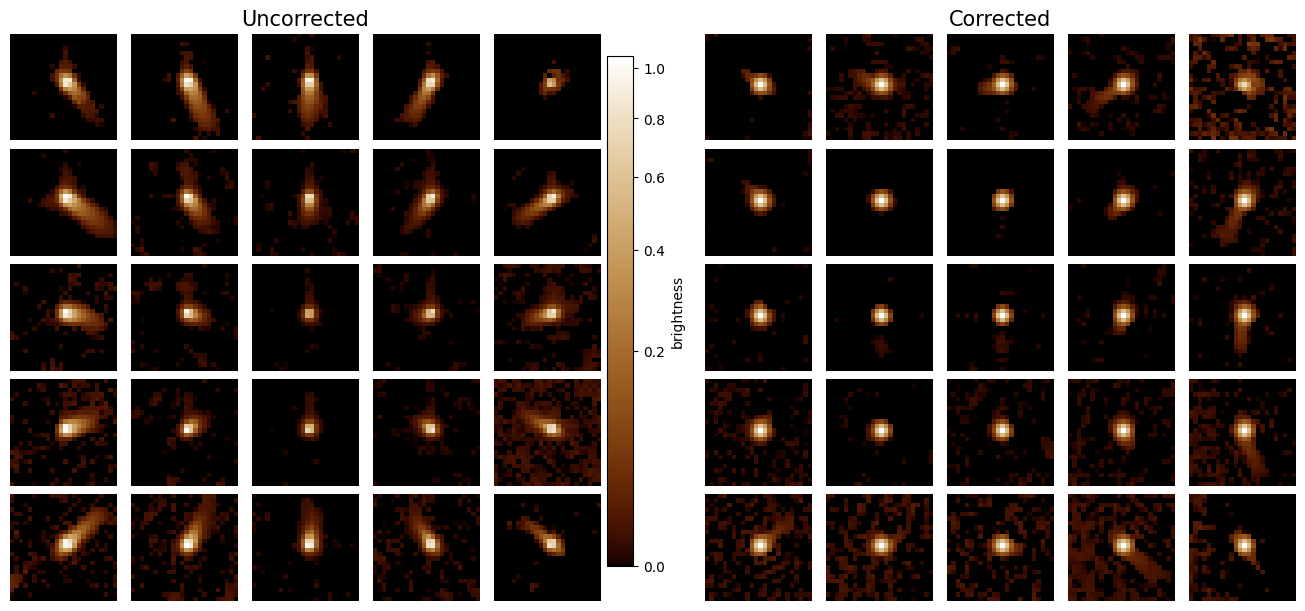

In [18]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
import matplotlib.pylab as pylab
import matplotlib.colors as colors
params = {'axes.titlesize': 15}
pylab.rcParams.update(params)

vmin = 0.05
vmax = np.max(uncorrected_patches)

fig = plt.figure(constrained_layout=True, figsize=(13, 6))

gs = GridSpec(5, 11, figure=fig, 
              width_ratios=[1, 1, 1, 1, 1, 0.8, 1, 1, 1, 1, 1],
              height_ratios=[1]*5)

uncorrected_axs = dict()
for i, j in itertools.product(range(5), range(5)):
    uncorrected_axs[i, j] = fig.add_subplot(gs[i, j])
for i in range(25):
    row, col = i % 5, i // 5
    im = uncorrected_axs[4-row, col].imshow(uncorrected_patches[i][4:-4, 4:-4], 
                                  origin='lower', cmap=custom, norm=colors.PowerNorm(gamma=1/2.2, vmin=vmin, vmax=vmax))
    uncorrected_axs[4-row, col].set_axis_off()
    uncorrected_axs[4-row, col].set_aspect(1)
    
cax = fig.add_axes([0.465, 0.065, 0.02, 0.85])
#fig.colorbar(im, cax=cax, orientation='vertical', label='log$_{10}$(brightness)')
fig.colorbar(im, cax=cax, orientation='vertical', label='brightness')

corrected_axs = dict()
for i, j in itertools.product(range(5), range(5)):
    corrected_axs[i, j] = fig.add_subplot(gs[i, j+6])
for i in range(25):
    row, col = i // 5, i % 5
    im = corrected_axs[4-row, col].imshow(corrected_patches[i][4:-4, 4:-4], 
                                    origin='lower', cmap=custom, norm=colors.PowerNorm(gamma=1/2.2, vmin=vmin, vmax=vmax))
    corrected_axs[4-row, col].set_axis_off()
    corrected_axs[4-row, col].set_aspect(1)

    
uncorrected_axs[0, 2].set_title("Uncorrected")
corrected_axs[0, 2].set_title("Corrected")
plt.show()
fig.savefig("../figures/punch.png")